## Análise dos dados
Notebook usado para obtenção das figuras utilizadas no estudo*. Como a lógica de tratamento de dados é exatamente a mesma do notebookPrincipal.ipynb (salvo partes específicas de modelagem para a construção das figuras), optei por removê-los do código abaixo.

*As Figuras 1 e 4 foram geradas, respectivamente, no [draw.io](http://draw.io) e no Excel. As Figuras 5 e 6 foram geradas no `notebookPrincipal.ipynb`.


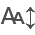

Lendo arquivo: data\ocorrenciasRJ.csv
CPU times: total: 922 ms
Wall time: 883 ms


In [1]:
%%time
from utils.preprocessamento_utils import *
from config.configs_dataframe import *
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import requests
from io import BytesIO
from shapely.geometry import Point

cores = {0: '#76b5c5', 1: '#ef8a62'}
cor_boxplot = cores[0]

configurar_ambiente()
df = carregar_datasets(caminho_datasets, configs_dataframe)

filtro = (df['br'] != 0) & (df['sentido_via'] != 'Não Informado') & (df['condicao_metereologica'] != 'Ignorado')
df = df[filtro]

df = calcular_frequencia_acidente(df)

df['gravidade'] = df.apply(define_gravidade, axis=1)

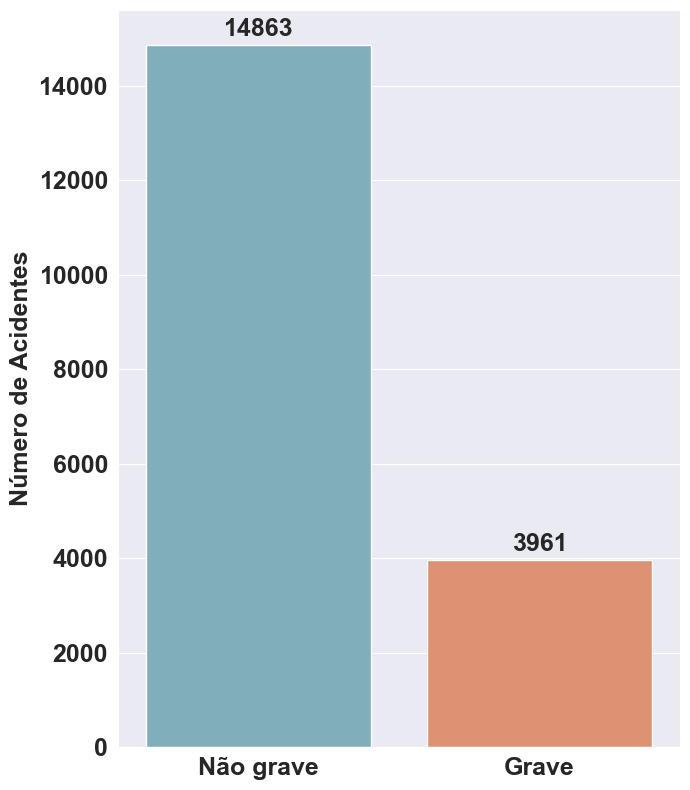

In [2]:
# -------------- FIGURA 3 -------------------
# todo: corrigir a ordem de criação das Figuras 2 e 3

contagem_gravidade = df['gravidade'].value_counts().sort_index().reset_index()
contagem_gravidade.columns = ['gravidade', 'contagem']

mapa_labels = {0: 'Não grave', 1: 'Grave'}
contagem_gravidade['gravidade'] = contagem_gravidade['gravidade'].map(mapa_labels)

plt.figure(figsize=(7,8))

paleta_ordenada = [cores[0], cores[1]]

barplot = sns.barplot(
    data=contagem_gravidade,
    x='gravidade',
    y='contagem',
    palette=paleta_ordenada
)

plt.xlabel('', fontsize=14, fontweight='bold')
plt.ylabel('Número de Acidentes', fontsize=18, fontweight='bold')
plt.xticks(fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')

for container in barplot.containers:
    barplot.bar_label(container, fontsize=18, padding=3, fontweight='bold')

plt.tight_layout()
plt.savefig(caminho_saida_figura("Fig 3.png"))
plt.show()

In [3]:
manter = ['data_inversa', 'dia_semana', 'horario', 'br', 'municipio', 'tipo_acidente',
         'fase_dia', 'sentido_via', 'condicao_metereologica', 'tipo_pista', 'tracado_via', 'uso_solo',
          'veiculos','latitude','longitude', 'gravidade', 'frequenciaAcidente']
df = df[manter]

df['emFeriado'] = df.apply(eh_feriado, axis=1)

df['data_inversa'] = df['data_inversa'].astype(str)
df['horario'] = df['horario'].astype(str)
df['mes'] = df['data_inversa'].str[5:7]
df['dia'] = df['data_inversa'].str[8:]
df['hora'] = df['horario'].str[:2]

converterInt = ['mes', 'dia', 'hora']
colunasCiclicas = ['mes', 'dia', 'hora']
df[converterInt] = df[converterInt].astype(int)

df['faseDoDia'] = define_fase_do_dia(df['hora'])
df.drop(columns=['hora', 'fase_dia'], axis=1, inplace=True)

valores = [12, 31]
df = converte_features_ciclicas(df, colunasCiclicas, valores)
df.drop(['data_inversa', 'horario'], axis=1, inplace=True)

dias = {
    ('segunda-feira', 'terça-feira', 'quarta-feira', 'quinta-feira', 'sexta-feira'): 0,
    ('sábado', 'domingo'): 1}
df['finalDeSemana'] = df['dia_semana'].apply(mapeador(dias))

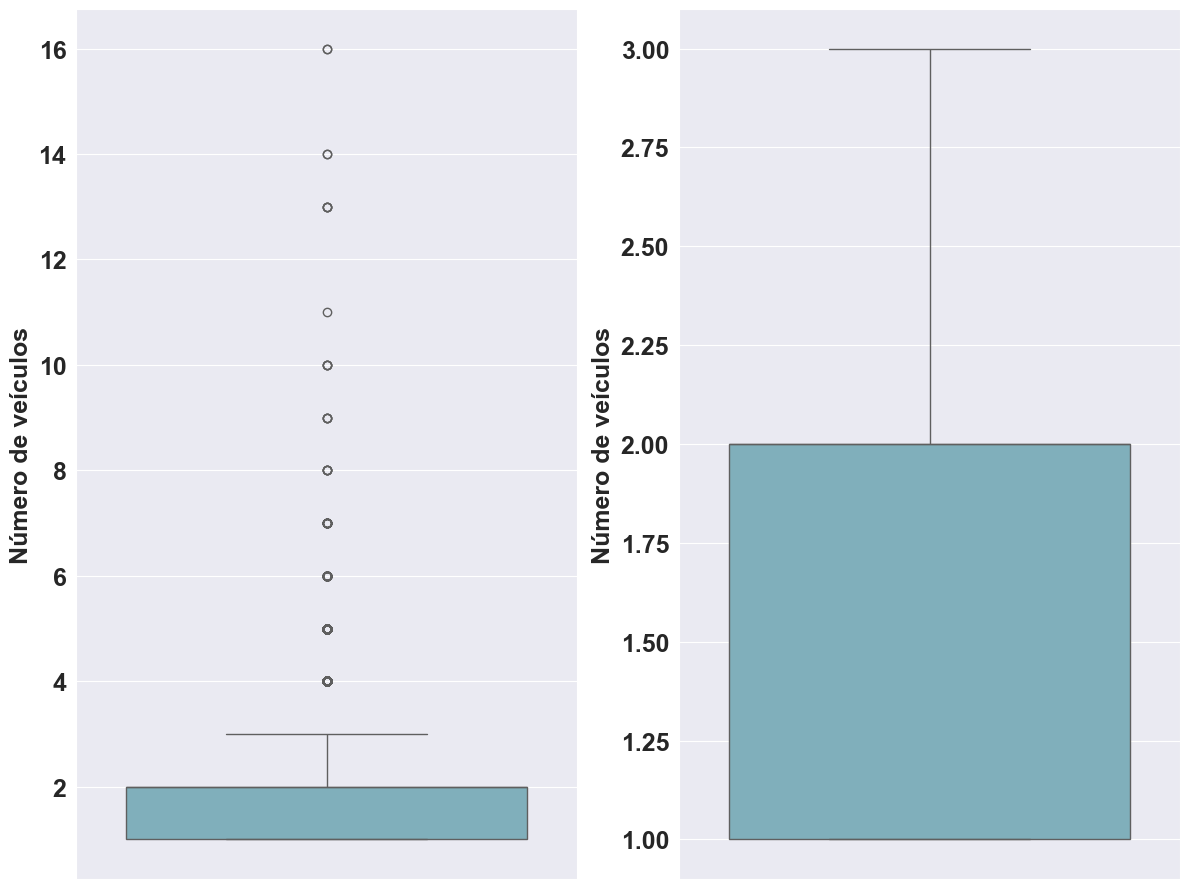

In [4]:
# -------------- FIGURA 2 -------------------
df_antes = df.copy()
df_depois, outliers = remove_outliers(df, ['veiculos'], contar_outliers=True)

plt.figure(figsize=(12,9))

plt.subplot(1, 2, 1)
sns.boxplot(y=df_antes['veiculos'], color=cor_boxplot)
plt.ylabel('Número de veículos', fontsize=18, fontweight='bold')
plt.xlabel('')
plt.xticks(fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')

plt.subplot(1, 2, 2)
sns.boxplot(y=df_depois['veiculos'], color=cor_boxplot)
plt.ylabel('Número de veículos', fontsize=18, fontweight='bold')
plt.xlabel('')
plt.xticks(fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')

plt.tight_layout()
plt.savefig(caminho_saida_figura("Fig 2.png"))
plt.show()

In [5]:
df['condicao_metereologica'] = df['condicao_metereologica'].replace('Ignorado', 'Céu Claro')

condicao_metereologica = {
    ('Céu Claro', 'Sol'): 'Boa',
    ('Garoa/Chuvisco', 'Nublado', 'Vento'): 'Média',
    ('Chuva', 'Nevoeiro/Neblina'): 'Ruim'
}

df['condicao_metereologica'] = df['condicao_metereologica'].apply(mapeador(condicao_metereologica))

df = categoriza_tracado_via(df)
df.drop(columns='tracado_via', inplace=True)

# Etapa adicional aqui: Corrigir e converter latitude/longitude
df['latitude'] = df['latitude'].str.replace(',', '.').astype(float)
df['longitude'] = df['longitude'].str.replace(',', '.').astype(float)

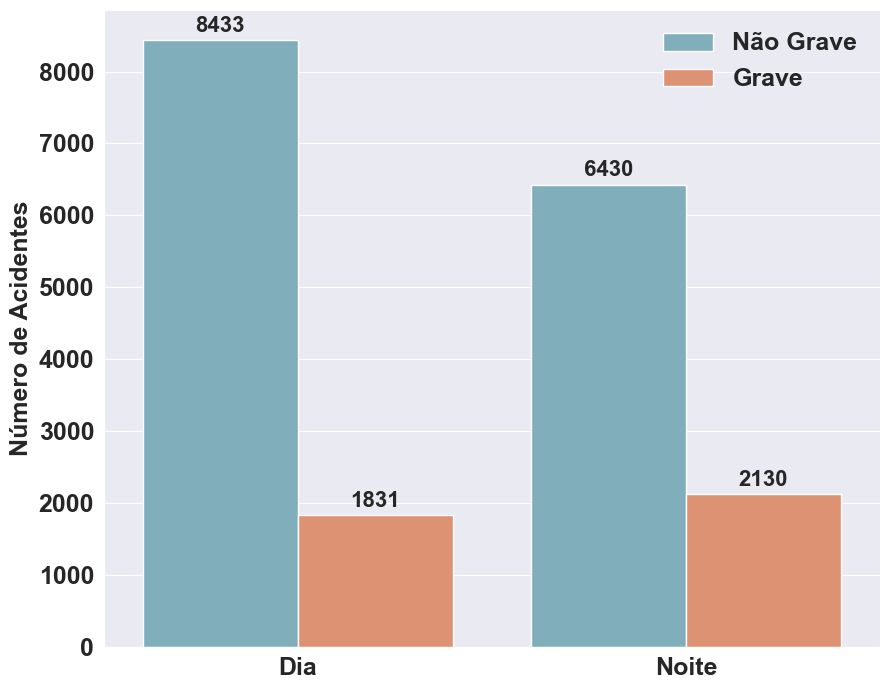

In [6]:
# -------------- FIGURA 7 -------------------
df['gravidade'] = df['gravidade'].astype(int)
tabela = df.groupby(['faseDoDia', 'gravidade']).size().reset_index(name='contagem')

plt.figure(figsize=(9, 7))
barplot = sns.barplot(
    data=tabela,
    x='faseDoDia',
    y='contagem',
    hue='gravidade',
    palette=cores
)

plt.ylabel('Número de Acidentes', fontsize=18, fontweight='bold')
plt.xlabel('')
plt.xticks(fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')

handles, labels = barplot.get_legend_handles_labels()
legend = barplot.legend(
    handles=handles,
    labels=['Não Grave', 'Grave'],
    fontsize=18,
    loc='upper right',
    frameon=False
)

for text in legend.get_texts():
    text.set_fontweight('bold')
for container in barplot.containers:
    barplot.bar_label(container, fontsize=16, padding=3, fmt='%d', fontweight='bold')

plt.tight_layout()
plt.savefig(caminho_saida_figura("Fig 7.png"))
plt.show()

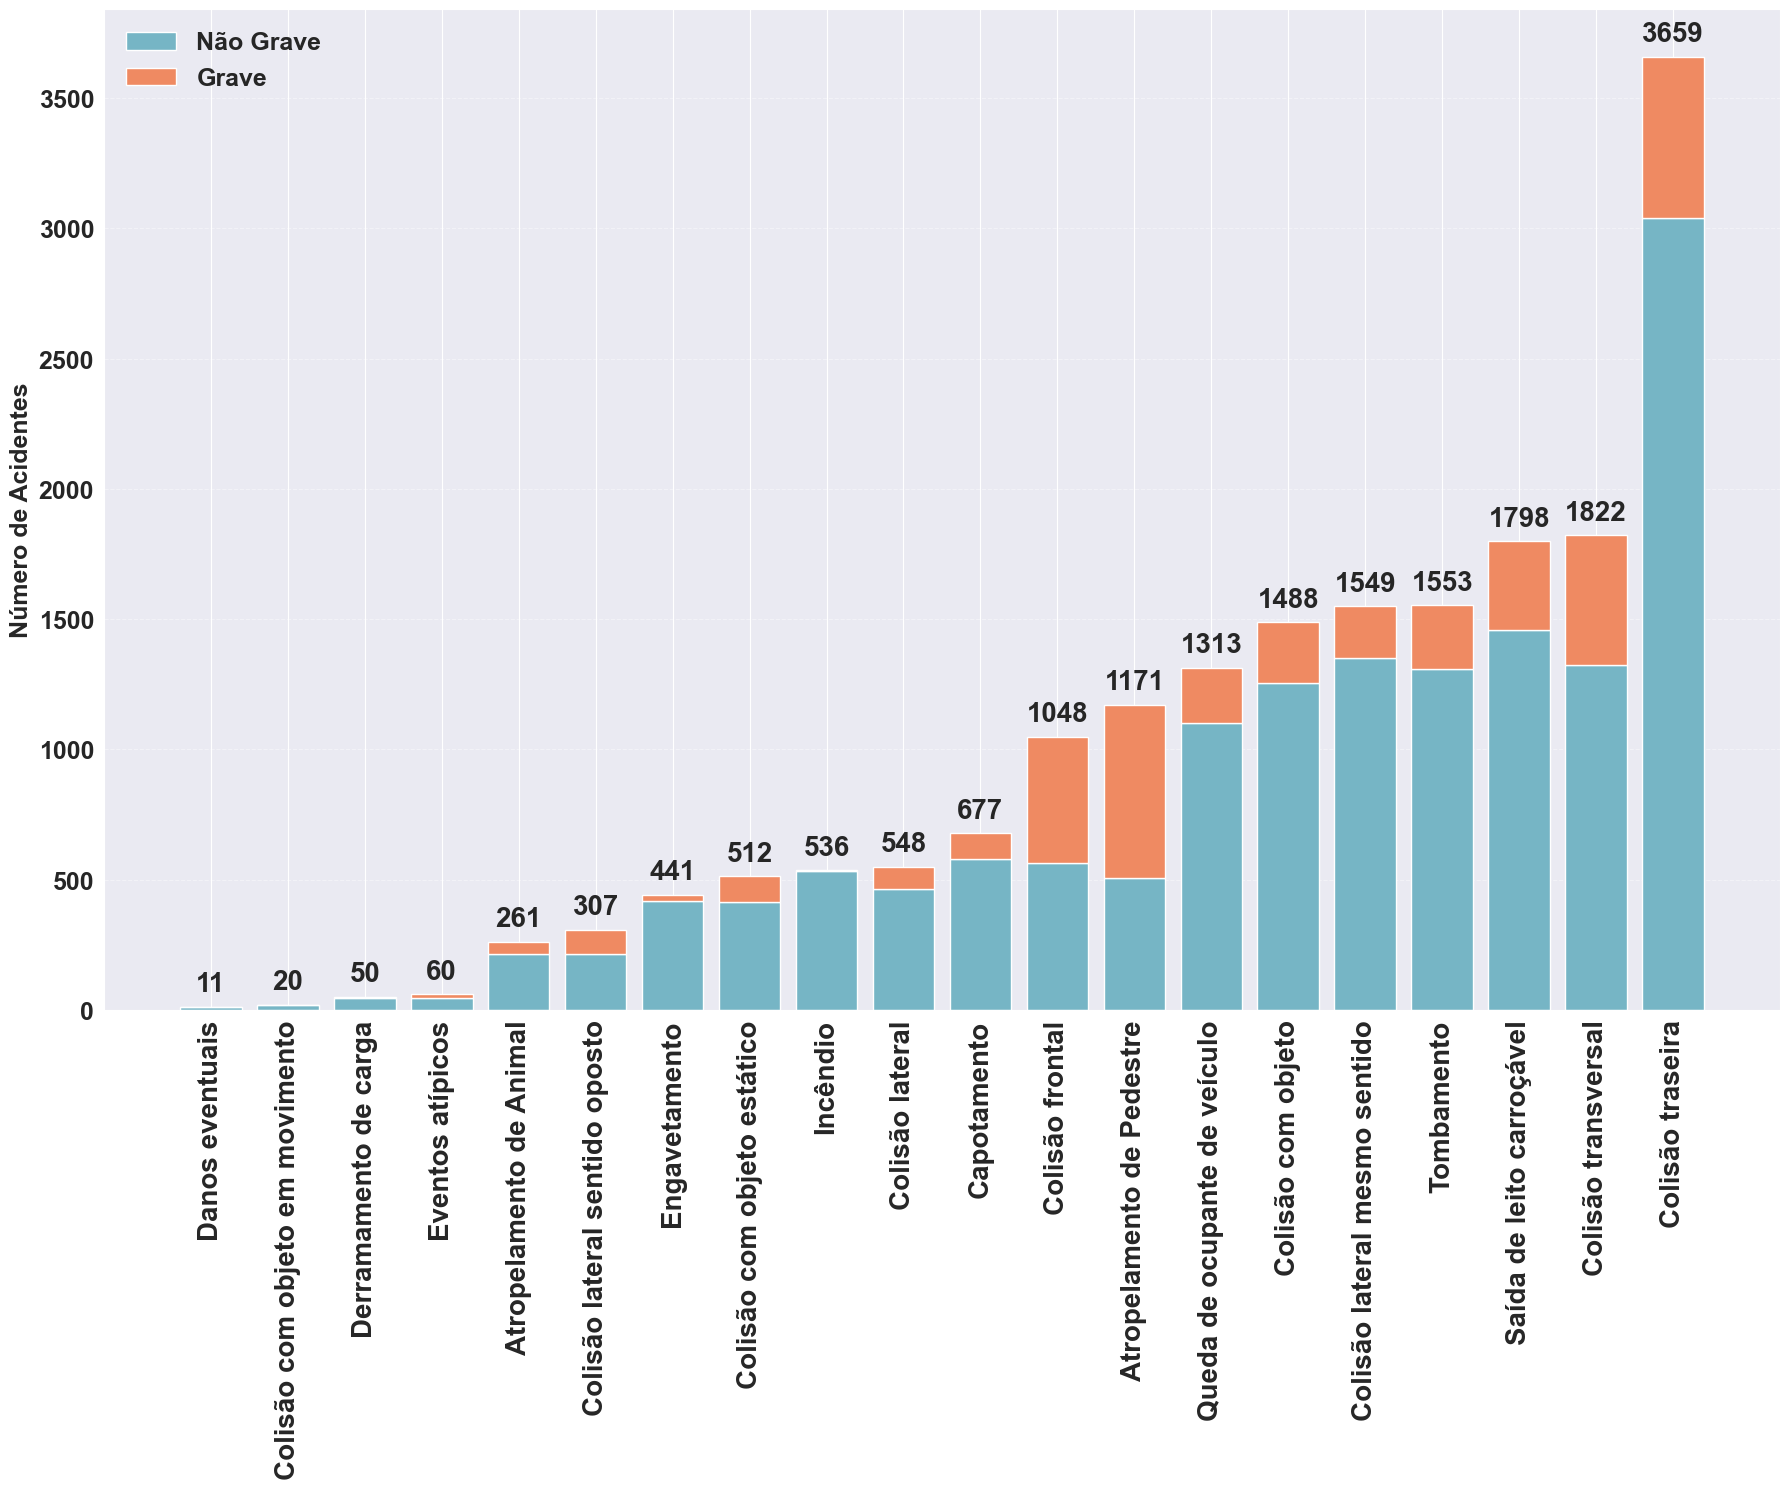

In [7]:
# -------------- FIGURA 8 -------------------
tabela = df.groupby(['tipo_acidente', 'gravidade']).size().reset_index(name='contagem')
ordem = tabela.groupby('tipo_acidente')['contagem'].sum().sort_values().index
pivot = tabela.pivot(index='tipo_acidente', columns='gravidade', values='contagem').fillna(0)
pivot = pivot.loc[ordem]

plt.figure(figsize=(18, 15))
bar1 = plt.bar(pivot.index, pivot[0], color=cores[0], label='Não Grave')
bar2 = plt.bar(pivot.index, pivot[1], bottom=pivot[0], color=cores[1], label='Grave')

plt.xlabel('')
plt.ylabel('Número de Acidentes', fontsize=18, fontweight='bold')
plt.xticks(rotation=90, fontsize=20, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')

legend = plt.legend(fontsize=18, loc='upper left', frameon=False)
for text in legend.get_texts():
    text.set_fontweight('bold')

plt.grid(axis='y', linestyle='--', alpha=0.4)

totais = pivot[0] + pivot[1]
for i, total in enumerate(totais):
    plt.text(i, total + max(totais)*0.01, str(int(total)), ha='center', va='bottom', fontsize=20, fontweight='bold')

plt.tight_layout()
plt.savefig(caminho_saida_figura("Fig 8.png"))
plt.show()

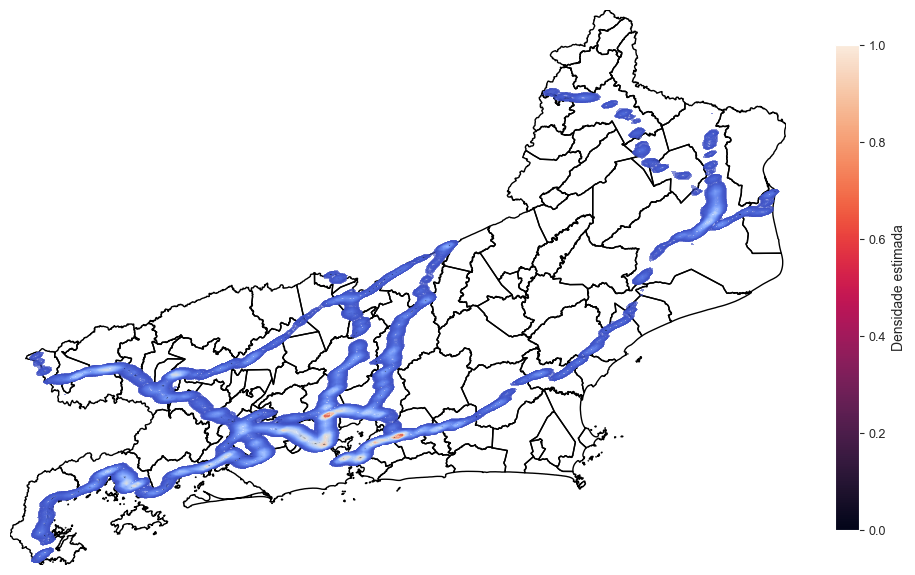

In [8]:
# -------------- FIGURA 9 -------------------
df_grave = df[df['gravidade'] == 1]

url = "https://servicodados.ibge.gov.br/api/v3/malhas/estados/33?formato=application/vnd.geo+json&qualidade=maxima&intrarregiao=municipio"
try:
    response = requests.get(url, timeout=10)
    response.raise_for_status()
    gdf_rj = gpd.read_file(BytesIO(response.content)).to_crs(epsg=3857)
except requests.exceptions.RequestException as e:
    print(f"Erro ao baixar o GeoJSON do IBGE: {e}")
    exit()


geometry = [Point(xy) for xy in zip(df_grave['longitude'], df_grave['latitude'])]
gdf_pts = gpd.GeoDataFrame(df_grave, geometry=geometry, crs='EPSG:4326').to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(10, 10))
gdf_rj.plot(ax=ax, facecolor='none', edgecolor='black')
x = gdf_pts.geometry.x
y = gdf_pts.geometry.y

kde = sns.kdeplot(
    x=x,
    y=y,
    fill=True,
    cmap="coolwarm",
    bw_adjust=0.1,
    alpha=0.6,
    ax=ax,
    levels=100,
    thresh=0.03
)

mappable = kde.get_children()[0]
cbar = fig.colorbar(mappable, ax=ax, shrink=0.5, label="Densidade estimada")
cbar.ax.tick_params(labelsize=9)

bounds = gdf_rj.total_bounds
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])

plt.axis("off")
plt.tight_layout()
plt.savefig(caminho_saida_figura("Fig 9.png"))
plt.show()